# You can call wave lib to read an audio file.

# To plot the waveform, use the "plot" function from matplotlib

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import numpy as np
import wave
import sys
import scipy.io.wavfile
from scipy.fftpack import dct

spf = wave.open('OSR_us_000_0010_8k.wav','r')
# #Extract Raw Audio from Wav File
# signal = spf.readframes(-1)
# signal = np.fromstring(signal, 'Int16')
fs = spf.getframerate()

#If Stereo
# if spf.getnchannels() == 2:
#     print ('Just mono files')
#     sys.exit(0)

sample_rate, signal = scipy.io.wavfile.read('OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

Time=np.linspace(0, len(signal)/fs, num=len(signal))

plt.figure()
plt.title('Signal Wave...')
plt.xlabel('Time(sec)')
plt.ylabel('AMPLITUDE')
plt.plot(Time, signal)
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
import wave
import struct
import numpy as np

data_size = 40000
fname = "OSR_us_000_0010_8k.wav"
frate = 11025.0
wav_file = wave.open(fname, 'r')
data = wav_file.readframes(data_size)
wav_file.close()
data = struct.unpack('{n}h'.format(n=data_size), data)
data = np.array(data)

w = np.fft.fft(data)
freqs = np.fft.fftfreq(len(w))
print(freqs.min(), freqs.max())
# (-0.5, 0.499975)

# Find the peak in the coefficients
idx = np.argmax(np.abs(w))
freq = freqs[idx]
freq_in_hertz = abs(freq * frate)
print(freq_in_hertz)
# 439.8975

-0.5 0.499975
297.12375000000003


FIRST STEP: 

A pre-emphasis filter is useful in several ways: 

(1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies

(2) avoid numerical problems during the Fourier transform operation

(3) may also improve the Signal-to-Noise Ratio (SNR).

In [3]:
pre_emphasis = 0.95 # applied on the signal to amplify the higher frequencies, as higher freq has less amplitude
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

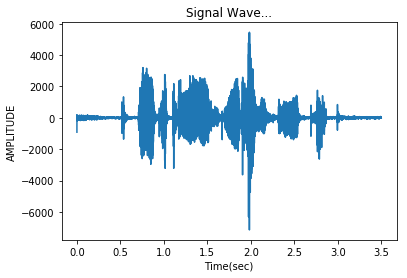

In [4]:
plt.figure()
plt.title('Signal Wave...')
plt.xlabel('Time(sec)')
plt.ylabel('AMPLITUDE')
plt.plot(Time, emphasized_signal)
plt.show()

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size

In [5]:
frame_size = 0.025          #   and a 10 ms stride (15 ms overlap), 
frame_stride = 0.01
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length

z = np.zeros((pad_signal_length - signal_length))

# Pad Signal to make sure that all frames have equal number of samples 
# without truncating any samples from the original signal

pad_signal = np.append(emphasized_signal, z) 


indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]


In [6]:
frames

array([[-919.  , -440.95,  199.3 , ...,   44.55,   99.4 ,   47.85],
       [ -55.7 ,    8.7 ,  -45.6 , ...,   47.75,  -16.7 ,  -12.45],
       [   9.75,  -33.05,  -29.05, ...,    3.25,   92.7 ,   83.65],
       ...,
       [  -2.1 ,   33.75,   26.4 , ...,   -5.25,  -54.5 ,  -44.25],
       [ -19.3 ,   -5.9 ,  -24.75, ...,   53.5 ,   23.65,   34.2 ],
       [ -17.9 ,   -5.75,    4.05, ...,    8.8 ,   33.2 ,   -5.15]])

# Window

After slicing the signal into frames, we apply a window function such as the Hamming window to each frame.

In [7]:
frames *= np.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

# Fourier-Transform and Power Spectrum

In [8]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [9]:
t =range(len(pow_frames ))
t = np.multiply(t,0.01)
len(t)

348

# FILTER BANKS

The final step to computing filter banks is applying triangular filters, typically 40 filters, on a Mel-scale to the power spectrum to extract frequency bands. 

 The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. 

In [10]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 10 * np.log10(filter_banks)  # dB


In [11]:
filter_banks.shape

(348, 40)

A spectrogram, or sonogram, is a visual representation of the spectrum of frequencies in a sound. Spectrograms are sometimes called spectral waterfalls, voiceprints, or voicegrams.

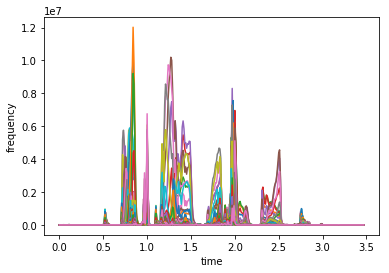

In [12]:
 #This code segment simply plots the power spectrum obtained above
plt.plot(t,pow_frames)
plt.ylabel('frequency')
plt.xlabel('time')
plt.show()

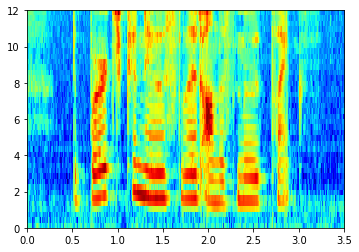

In [13]:
plt.imshow(np.flipud(filter_banks.T), cmap = cm.jet, aspect=0.2, extent=[0,3.5,0,12])

If the Mel-scaled filter banks were the desired features then we can skip to mean normalization

# Mel-frequency Cepstral Coefficients (MFCCs)


In [14]:
num_ceps = 12

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
len(mfcc)

348

One may apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals.

cep_lifter is a parameter typically set to 22 in most implementations. However, it refers to the dimensionality of the MFCC vector in the original formulation.

In [15]:
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + ( 12/ 2) * np.sin(np.pi * n / 12)
mfcc *= lift  
mfcc

array([[-21.49715037,  10.11809839,  17.17917946, ..., -31.58294226,
          4.49079078,  15.96284539],
       [-16.08914214,   3.19729899,  42.86740085, ..., -43.56948818,
        -31.6826136 ,  19.44796626],
       [-27.64285574,  12.67185943,  40.15815249, ..., -10.57178491,
          2.94064738,  27.61607993],
       ...,
       [  6.12131784,  28.42580847,  22.82958598, ..., -17.83449559,
         -6.52374744, -19.70896322],
       [ 10.05550425,  33.31375322,  26.5555213 , ..., -18.45592635,
         -6.3029206 ,  -7.27862228],
       [  4.11817325,  48.51676241,  43.43285038, ..., -25.2624283 ,
         24.72051912,   8.53916008]])

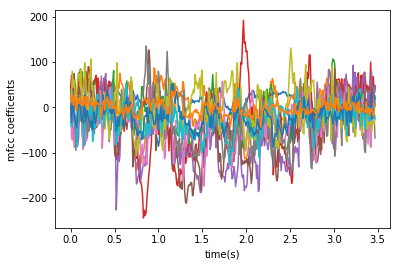

In [16]:
plt.plot(t,mfcc)
plt.ylabel('mfcc coefficents')
plt.xlabel('time(s)')
plt.show()

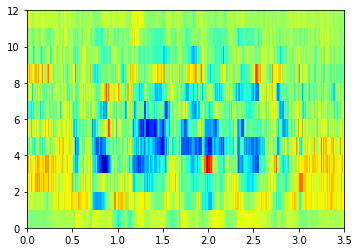

In [17]:
plt.imshow(np.flipud(mfcc.T), aspect=0.2, extent=[0,3.5,0,12],cmap =cm.jet) # very important

In [18]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
N = 1000

# Mean Normalization
As previously mentioned, to balance the spectrum and improve the Signal-to-Noise (SNR), we can simply subtract the mean of each coefficient from all frames.

In [20]:
# For Filter_banks
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
filter_banks.shape

(348, 40)

In [ ]:
plt.imshow(np.flipud(filter_banks.T), cmap = cm.jet, aspect=0.2, extent=[0,3.5,0,12])
print('The mean-normalized Filter_banks')

In [ ]:
# For MFCCs
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

In [ ]:
plt.imshow(np.flipud(mfcc.T), cmap =cm.jet, aspect=0.2, extent=[0,3.5,0,12])
print('The mean-normalized MFCCs:')

In [ ]:
# def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
#     """
#     creates a spectrogram
#     log: take the log of the spectrgram
#     thresh: threshold minimum power for log spectrogram
#     """
#     specgram = np.abs(signal.stft(d, nfft = fft_size, nperseg=step_size))
  
#     if log == True:
#         specgram /= specgram.max() # volume normalize to max 1
#         specgram = np.log10(specgram) # take log
#         specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
#     else:
#         specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
#     return specgram

In [ ]:
# from scipy import signal
# ### Parameters ###
# fft_size = 2048 # window size for the FFT
# step_size = fft_size/16 # distance to slide along the window (in time)
# spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
# lowcut = 500 # Hz # Low cut for our butter bandpass filter
# highcut = 15000 # Hz # High cut for our butter bandpass filter

# # For mels
# n_mel_freq_components = 64 # number of mel frequency channels
# shorten_factor = 10 # how much should we compress the x-axis (time)
# start_freq = 300 # Hz # What frequency to start sampling our melS from 
# end_freq = 8000 # Hz # What frequency to stop sampling our melS from 